In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.stats import norm

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

current_dir = Path().resolve()
parent_dir = current_dir.parent
sys.path.insert(0, str(parent_dir))

from model.kalman_heston_filter import kalman_like_heston_filter
from model.heston_mod import heston_DGP

In [56]:
df = pd.read_csv("/Users/hyunminhong/Kalman-Heston-Filter/data/oxfordmanrealizedvolatilityindices.csv")

df = df.rename(columns={'Unnamed: 0': 'Time'})
df = df.loc[df['Symbol']=='.SPX'].reset_index(drop=True)
df['Time'] = pd.to_datetime(df['Time'], utc=True) 
df['Time'] = df['Time'].dt.date
df = df.set_index('Time')
df.index = pd.to_datetime(df.index)

In [57]:
df = df.loc[pd.to_datetime('2014-01-01'):pd.to_datetime('2018-06-01')]

# Distribution of RV

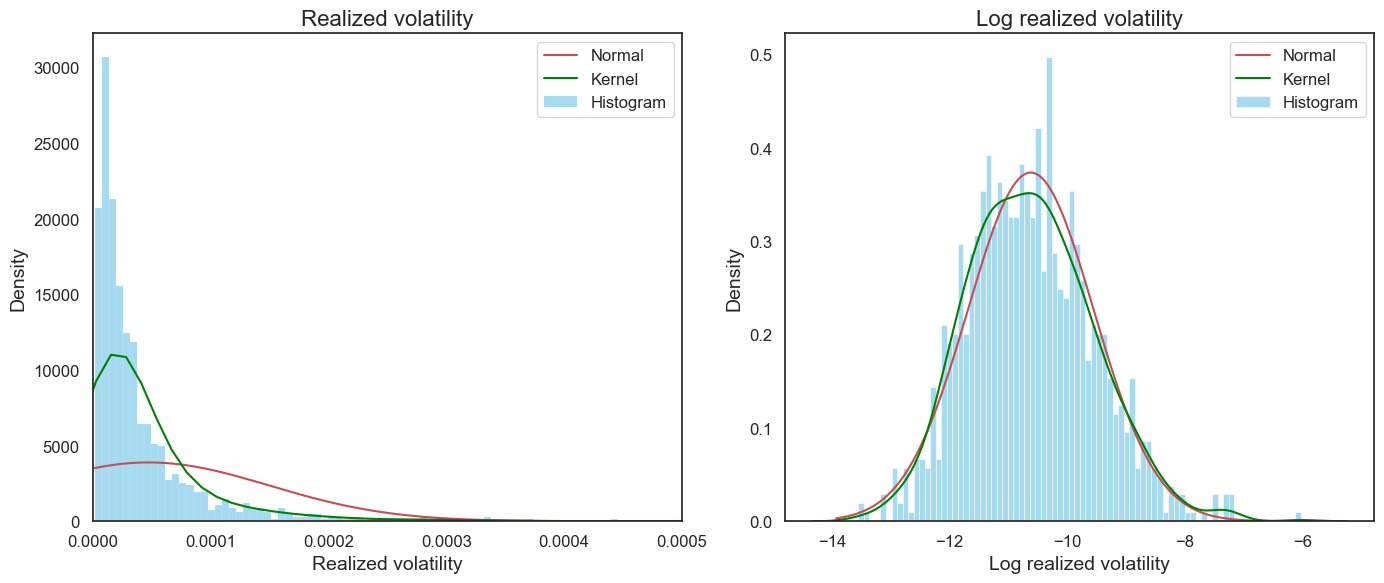

In [68]:
rv = df['rv10'].dropna()
log_rv = np.log(rv)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(rv, kde=False, stat='density', bins=400, color='skyblue', ax=ax[0], label='Histogram')

xmin, xmax = rv.min(), rv.max()
x_vals = np.linspace(xmin, xmax, 500)
mu, std = norm.fit(rv)
ax[0].plot(x_vals, norm.pdf(x_vals, mu, std), 'r', label='Normal')

sns.kdeplot(rv, ax=ax[0], color='green', label='Kernel')

ax[0].set_title('Realized volatility', fontsize=16)
ax[0].set_xlabel('Realized volatility', fontsize=14)
ax[0].set_ylabel('Density', fontsize=14)
ax[0].set_xlim(0, 0.0005)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].legend(fontsize=12)

sns.histplot(log_rv, kde=False, stat='density', bins=80, color='skyblue', ax=ax[1], label='Histogram')
xmin, xmax = ax[1].get_xlim()
x_vals = np.linspace(xmin, xmax, 500)
mu_log, std_log = norm.fit(log_rv)
ax[1].plot(x_vals, norm.pdf(x_vals, mu_log, std_log), 'r', label='Normal')
sns.kdeplot(log_rv, ax=ax[1], color='green', label='Kernel')

ax[1].set_title('Log realized volatility', fontsize=16)
ax[1].set_xlabel('Log realized volatility', fontsize=14)
ax[1].set_ylabel('Density', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(fontsize=12)

plt.tight_layout()
plt.show()

# Autocorrelation

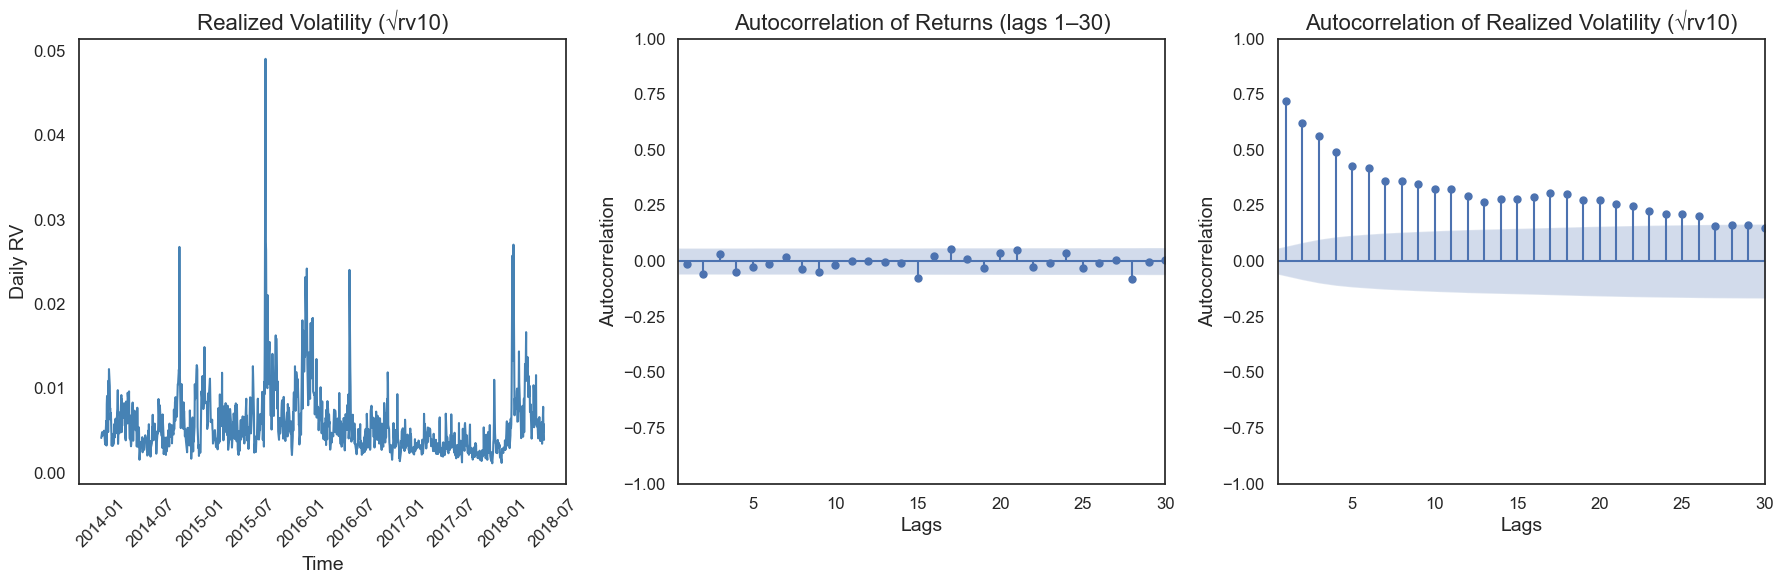

In [64]:
returns = np.log(df['close_price']).diff().iloc[1:]
rv10 = df['rv10'].iloc[1:]
realized_vol = np.sqrt(rv10)

sns.set(style='white')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Volatility plot 
sns.lineplot(x=realized_vol.index, y=realized_vol.values, ax=axes[0], color='steelblue')
axes[0].set_title('Realized Volatility (√rv10)', fontsize=16)
axes[0].set_xlabel('Time', fontsize=14)
axes[0].set_ylabel('Daily RV', fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# 2. Autocorrelation of returns
plot_acf(returns, lags=30, ax=axes[1])
axes[1].set_title('Autocorrelation of Returns (lags 1–30)', fontsize=16)
axes[1].set_xlabel('Lags', fontsize=14)
axes[1].set_ylabel('Autocorrelation', fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_xlim(0.5, 30)

# 3. Autocorrelation of realized volatility
plot_acf(realized_vol, lags=30, ax=axes[2])
axes[2].set_title('Autocorrelation of Realized Volatility (√rv10)', fontsize=16)
axes[2].set_xlabel('Lags', fontsize=14)
axes[2].set_ylabel('Autocorrelation', fontsize=14)
axes[2].tick_params(axis='both', labelsize=12)
axes[2].set_xlim(0.5, 30)

plt.tight_layout()
plt.show()